<a href="https://colab.research.google.com/github/Sahanaka/fyp-main-blocks/blob/main/models/deeplearning/DNNModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Exploratory data analysis
# install package in current jupytor kernel
import sys
!{sys.executable} -m pip install librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# upload audio file

from google.colab import drive
drive.mount('/content/gdrive/')

curr_dir = "/content/gdrive/My Drive/Final Year Project/Dataset/"

audio = "/content/gdrive/My Drive/Final Year Project/Dataset/audio.mp3"

Mounted at /content/gdrive/


In [ ]:
import IPython.display as ipd
import librosa
import librosa.display

In [ ]:
ipd.Audio(audio)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


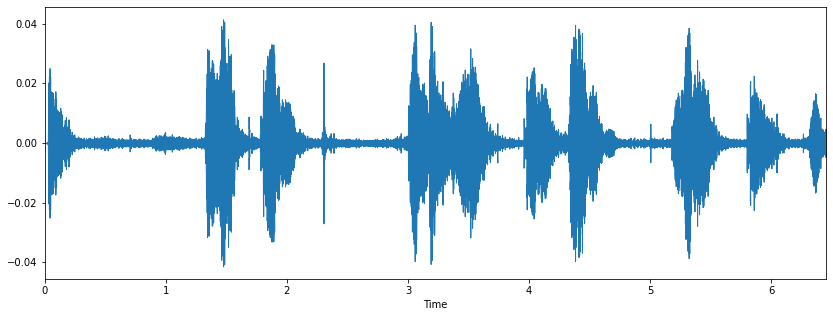

In [ ]:
plt.figure(figsize=(14,5))
data,sample_rate = librosa.load(audio)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(audio)

In [ ]:
sample_rate, data

(22050, array([-4.6812243e-06, -4.9872456e-06,  1.6950436e-06, ...,
        -2.8247996e-03, -2.8452177e-03, -2.5189293e-03], dtype=float32))

##Extract Features

In [ ]:
# extracting mfcc for every audio file
import pandas as pd
import os
import librosa

audio_data = "/content/gdrive/My Drive/FYP Data/Audio Binary Classification/defective/"
data_set = pd.read_csv("/content/gdrive/My Drive/FYP Data/Audio Binary Classification/csv_audio_binary_classification.csv")
data_set.head()


,Name,fold,class_id,class
0,87126efc-63cf-448b-b04c-d8b1de986221_cut.part1...,unh3_not_severe_level3,1,defective
1,87126efc-63cf-448b-b04c-d8b1de986221_cut.part2...,unh3_not_severe_level3,1,defective
2,87126efc-63cf-448b-b04c-d8b1de986221_cut.part3...,unh3_not_severe_level3,1,defective
3,87126efc-63cf-448b-b04c-d8b1de986221_cut.part5...,unh3_not_severe_level3,1,defective
4,87126efc-63cf-448b-b04c-d8b1de986221_cut.part4...,unh3_not_severe_level3,1,defective


In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [ ]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(data_set.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_data),'fold'+str(row["fold"])+'/',str(row["Name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

123it [00:53,  2.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=67
  n_fft, y.shape[-1]
136it [00:59,  2.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=177
  n_fft, y.shape[-1]
147it [01:03,  2.76it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=243
  n_fft, y.shape[-1]
167it [01:13,  1.89it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=111
  n_fft, y.shape[-1]
175it [01:16,  2.30it/s]


In [ ]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-318.00528, 103.05953, 18.404898, 37.85635, 5...",defective
1,"[-356.4744, 111.317924, 17.381718, 38.607315, ...",defective
2,"[-349.36356, 103.87671, 14.324061, 40.407364, ...",defective
3,"[-333.19797, 107.1859, 8.152057, 40.582455, -0...",defective
4,"[-340.35153, 110.18605, 10.904561, 37.52921, 3...",defective


In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(175, 40)

In [ ]:
y

array(['defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defective',
       'defective', 'defective', 'defective', 'defective', 'defe

In [ ]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [ ]:

### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X_train.shape

(140, 40)

In [ ]:
y_train.shape

(140, 2)

## Model Creation

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
num_labels=y.shape[1]

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
5/5 [==============================] - 1s 57ms/step - loss: 16.8253 - accuracy: 0.5714 - val_loss: 7.5030 - val_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 7.50297, saving model to saved_models/audio_classification.hdf5
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 15.0272 - accuracy: 0.5429 - val_loss: 9.0071 - val_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 7.50297
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 11.8344 - accuracy: 0.6071 - val_loss: 4.6830 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 7.50297 to 4.68300, saving model to saved_models/audio_classification.hdf5
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 10.6036 - accuracy: 0.5714 - val_loss: 1.5042 - val_accuracy: 0.8000

Epoch 00004: val_loss improved from 4.68300 to 1.50425, saving model to saved_models/audio_classification.hdf5
Epoch 5/100
5/5 [==============================] - 0s

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8857142925262451


In [ ]:
# model.predict_classes(X_test)
# predict_classes function were removec in tf 2.6 onwards

In [ ]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
classes_x

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])

In [ ]:
# this is defective patient
filename="/content/gdrive/My Drive/FYP Data/Audio Binary Classification/Music Editor  Trim, Extract, Convert and Mix Audio2021_10_02_12_14_37.mp3"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label1=model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_label1,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[-5.01386017e+02  8.42320023e+01  1.51415615e+01  3.89825058e+01
 -7.86411953e+00  1.08085938e+01 -1.26447744e+01  1.46623015e+00
 -2.17547016e+01  6.43502951e+00 -1.16317005e+01  5.77531147e+00
 -1.09728003e+01  9.79197884e+00 -7.19198513e+00  3.21503711e+00
 -1.81193328e+00  3.75844622e+00 -5.84027386e+00  3.18860126e+00
 -7.39463377e+00  1.52933872e+00 -5.11653471e+00 -1.64669156e+00
 -5.92173910e+00 -3.41603208e+00 -5.54900265e+00 -2.99401665e+00
 -3.99346042e+00  1.96378827e-01  2.07779914e-01  2.68574882e+00
  3.08579445e+00  2.72122955e+00  3.22960258e+00  3.05229211e+00
  3.36691642e+00  3.82118440e+00  3.95857120e+00  4.30322123e+00]
[[-5.01386017e+02  8.42320023e+01  1.51415615e+01  3.89825058e+01
  -7.86411953e+00  1.08085938e+01 -1.26447744e+01  1.46623015e+00
  -2.17547016e+01  6.43502951e+00 -1.16317005e+01  5.77531147e+00
  -1.09728003e+01  9.79197884e+00 -7.19198513e+00  3.21503711e+00
  -1.81193328e+00  3.75844622e+00 -5.84027386e+00  3.18860126e+00
  -7.39463377e+00  

array(['defective'], dtype='<U13')

In [ ]:
# this is defective patient
filename="/content/gdrive/My Drive/FYP Data/Audio Binary Classification/videoplayback (1)_cut.part2_cut.WAV"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label1=model.predict(mfccs_scaled_features)
predicted_label = np.argmax(predicted_label1,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-2.8047577e+02  1.0775197e+02  1.5927013e+01  1.2246117e+01
 -3.3863106e+01  2.3034017e+00 -8.5426941e+00  2.5266239e+01
 -2.9474541e+01 -4.6566525e+00 -9.8201218e+00  1.7416195e+01
 -9.9181576e+00 -1.2405012e+01 -6.9484978e+00  9.4371092e-01
 -8.6907396e+00 -1.4030788e+01 -1.2323513e+01  2.4255023e+00
 -6.9605846e+00  1.7250495e+00 -1.0756279e+01  1.6085072e+00
  6.3476145e-02  8.9765263e-01 -7.8010473e+00 -3.6808834e+00
  1.1903636e-01 -6.7911530e+00 -8.7897320e+00 -3.4692862e+00
 -4.8581409e+00  2.0130706e+00  3.5038084e-01 -4.7220650e+00
 -2.8556619e+00  8.3592045e-01 -2.8888626e+00 -4.5882940e+00]
[[-2.8047577e+02  1.0775197e+02  1.5927013e+01  1.2246117e+01
  -3.3863106e+01  2.3034017e+00 -8.5426941e+00  2.5266239e+01
  -2.9474541e+01 -4.6566525e+00 -9.8201218e+00  1.7416195e+01
  -9.9181576e+00 -1.2405012e+01 -6.9484978e+00  9.4371092e-01
  -8.6907396e+00 -1.4030788e+01 -1.2323513e+01  2.4255023e+00
  -6.9605846e+00  1.7250495e+00 -1.0756279e+01  1.6085072e+00
   6.3476145e-02 

array(['defective'], dtype='<U13')